### Set parameters

In [2]:
type = "real_exp"
device = 'nano'
model = "densenet201"
date_label = "0106"

# Import

In [3]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [24]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
colors_fill = [None, "#54637C", "#587C86", "#5D928B","#65A68D", 
               "#71B88E", "#83C98F", "#9CD790", "#BBE394", 
               "#D9ED9D", "#F1F4B0", "#FEFAD3"]
grid_color = 'gainsboro'

In [5]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    if device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [6]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 
          'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [7]:
for save_format in save_formats:
    directory_path = f'./{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './png'가 이미 존재합니다.
디렉터리 './pdf'가 이미 존재합니다.
디렉터리 './svg'가 이미 존재합니다.


### Load csv & Dataframe 생성

##### 1. toy_simul

In [8]:
if type == "toy_simul":
    models = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
    # model = models[2]
    max_cores = 10
    # max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    contention_overhead_percent = 10

In [9]:
if type == "toy_simul":
    if model == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")
    layer_num = len(cpu_inference_list)

In [10]:
if type == "toy_simul":
    e_preprocess = 0
    e_postprocess = 0
    e_inference_cpu = sum(cpu_inference_list)
    e_inference_gpu = sum(gpu_inference_list)

In [11]:
if type == "toy_simul":
    # 데이터 저장을 위한 딕셔너리
    average_execution_times = {}
    throughput = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)',
              'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']

In [12]:
if type == "toy_simul":
    # Calculations for Sequential (Full CPU)
    e_inference_cpu = sum(cpu_inference_list)
    delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
    average_execution_times["Seq\n(Full CPU)"] = delay_seq_cpu

    throughput["Seq\n(Full CPU)"] = 1 / delay_seq_cpu * 1000

    block_loss_seq_cpu = 0
    block_losses["Seq\n(Full CPU)"] = block_loss_seq_cpu



    # Calculations for Pipeline (Full CPU)
    max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
    if max_stage_cpu == e_preprocess:
        pipeline_stall_cpu = e_preprocess - e_inference_cpu
    elif max_stage_cpu == e_inference_cpu:
        pipeline_stall_cpu = e_inference_cpu - e_preprocess
    else:
        pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
    block_losses["TPA\n(Full CPU)"] = pipeline_stall_cpu

    delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
    average_execution_times["TPA\n(Full CPU)"] = delay_tpa_cpu

    throughput_tpa_cpu = 1 / max_stage_cpu * 1000
    throughput["TPA\n(Full CPU)"] = throughput_tpa_cpu


    # Calculations for Data-parallel (Full CPU)
    contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
    # block_losses["DPA\n(Full CPU)"] = contention_overhead_cpu

    delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
    throughput_dpa_cpu = 1 / (delay_dpa_cpu / max_cores) * 1000
    throughput["DPA\n(Full CPU)"] = throughput_dpa_cpu

    block_loss_dpa_cpu = 0
    block_losses["DPA\n(Full CPU)"] = block_loss_dpa_cpu

    delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu
    average_execution_times["DPA\n(Full CPU)"] = delay_dpa_cpu


    # Calculations for Sequential (Full GPU)
    e_inference_gpu = sum(gpu_inference_list)
    delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
    average_execution_times["Seq\n(Full GPU)"] = delay_seq_gpu

    throughput_seq_gpu = 1 / delay_seq_gpu * 1000
    throughput["Seq\n(Full GPU)"] = throughput_seq_gpu

    block_loss_seq_gpu = 0
    block_losses["Seq\n(Full GPU)"] = block_loss_seq_gpu


    # Calculations for Pipeline (Full GPU)
    max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
    if max_stage_gpu == e_preprocess:
        pipeline_stall_gpu = e_preprocess - e_inference_gpu
    elif max_stage_gpu == e_inference_gpu:
        pipeline_stall_gpu = e_inference_gpu - e_preprocess
    else:
        pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
    block_losses["TPA\n(Full GPU)"] = pipeline_stall_gpu

    delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
    average_execution_times["TPA\n(Full GPU)"] = delay_tpa_gpu

    throughput_tpa_gpu = 1 / max_stage_gpu * 1000
    throughput["TPA\n(Full GPU)"] = throughput_tpa_gpu


    # Calculations for Data-parallel (Full GPU)
    contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100

    delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
    throughput_dpa_gpu = 1 / max(delay_dpa_gpu / max_cores, e_inference_gpu) * 1000
    throughput["DPA\n(Full GPU)"] = throughput_dpa_gpu

    block_loss_dpa_gpu = e_inference_gpu * (max_cores-1) - (e_preprocess+e_postprocess)
    if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
    block_losses["DPA\n(Full GPU)"] = block_loss_dpa_gpu

    delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu
    average_execution_times["DPA\n(Full GPU)"] = delay_dpa_gpu

    accel_gain = e_inference_cpu - e_inference_gpu
    accel_gains["Seq\n(Full GPU)"] = accel_gain
    accel_gains["TPA\n(Full GPU)"] = accel_gain
    accel_gains["DPA\n(Full GPU)"] = accel_gain

    for label in labels:
        pre_components[label] = e_preprocess
        if label[-4:-1] == "CPU":
            infer_components[label] = e_inference_cpu
        else:
            infer_components[label] = e_inference_gpu
        post_components[label] = e_postprocess
        block_components[label] = block_losses[label]


2. real_simul

In [13]:
if type == 'real_simul':
    max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    layer_num = layerNum(model)
    if not os.path.exists(f"../../csv/{date_label}"):
        print(f"Invalid date: {date_label}")

    contention_overhead_percent = 0

In [14]:
if type == 'real_simul':
    cpu_file_path = f'../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv'
    gpu_file_path = f'../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv'

In [15]:
if type == 'real_simul':
    cpu_data = pd.read_csv(cpu_file_path)

    e_preprocess = np.mean(cpu_data["e_preprocess"])
    e_postprocess = np.mean(cpu_data["e_postprocess"])

    layer_columns = [col for col in cpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_cpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_cpu[col_number] = cpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

        
    gpu_data = pd.read_csv(gpu_file_path)

    layer_columns = [col for col in gpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_gpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_gpu[col_number] = gpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

    # CPU와 GPU 인퍼런스 리스트 생성
    cpu_inference_list = list(layer_averages_cpu.values())
    gpu_inference_list = list(layer_averages_gpu.values())

##### [TODO]
##### 아래 두 블럭 무슨 기능하는지 확인하기
###### reference code 본 결과, layer_time 정보로 simulation으로 계산하는 부분으로 보임

In [16]:
if type == 'real_simul':
    # Preprocess Layer와 Postprocess Layer 앞 뒤에 넣기
    layer_num = len(cpu_inference_list)
    print(e_preprocess, e_postprocess)
    cpu_inference_list.insert(0, e_preprocess)
    cpu_inference_list.append(e_postprocess)
    gpu_inference_list.insert(0, 0)
    gpu_inference_list.append(0)


    # acceleration_type 앞 뒤에 CPU (0) 넣기
    # [0,M] & [start, M] 구성 찾기
    all_results = []
    acceleration_type = []

    # 모든 start 값에 대한 배열 생성
    for start in range(0, 1):
        result = []
        for i in range(start, layer_num):
            row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num - (i + 1)) + [0]
            result.append(row)
            acceleration_type.append(row)
        all_results.append(result)
    # print(acceleration_type)
    acceleration_type.sort(key=lambda x: (x.count(1), next((i for i, v in enumerate(x) if v == 1), layer_num+2)))
    # print(acceleration_type)

    layer_num = len(cpu_inference_list)
    print(len(acceleration_type))
    print(len(acceleration_type[0]))
    print(layer_num)

In [17]:
if type == 'real_simul':
    num_thread = max_cores
    num_repeat = 100  # 반복 횟수

    output_cycle_time = []
    output_frame_rate = []
    max_execution_time_list = []
    min_execution_time_list = []
    avg_execution_time_list = []
    total_execution_time_list = []
    throughput_list = []
    acceleration_gain_list = []
    block_time_list = []
    num_accelerated_layer_list = []

    for test_case in range(0, len(acceleration_type)):
        # target_case 가져오기
        target_case = acceleration_type[test_case]
        count_of_ones = target_case.count(1)
        num_accelerated_layer_list.append(count_of_ones)
        # if test_case == 1: print(target_case)
        
        # 연속된 0과 1을 segment 단위로 묶기
        segments = [list(g) for k, g in groupby(target_case)]
        # if test_case == 1: print(segments)
        
        # 각 segment의 delay 및 타입 계산
        segment_delays = []
        segment_types = []
        start_idx = 0
        
        for segment in segments:
            segment_type = segment[0]  # 0 (CPU) 또는 1 (GPU)
            segment_length = len(segment)
            
            # 해당 segment의 delay 계산
            if segment_type == 0:
                delay = sum(cpu_inference_list[start_idx:start_idx + segment_length])
                segment_types.append("cpu")
            else:
                delay = sum(gpu_inference_list[start_idx:start_idx + segment_length])
                segment_types.append("gpu")
            
            segment_delays.append(delay)
            start_idx += segment_length  # 다음 segment의 시작 인덱스 업데이트
        
        # 결과 출력
        # for i, (delay, segment_type) in enumerate(zip(segment_delays, segment_types)):
        #     print(f"Segment {i + 1}: Type = {segment_type}, Delay = {delay}")
        
        segment_type = segment_types
        segment_delay = segment_delays
        
        regular_output_list = []
        total_delay_ = sum(segment_delay)
        
        for input_pattern in range(0, 1):
            data_arrival_interval = input_pattern
        
            task_start_time = [i * data_arrival_interval for i in range(num_thread * num_repeat)]  # [0, 5, 10, 15, 20, 25]
            gpu_available_time = [[[0, float('inf')]] for _ in range(num_thread)]
            segment_end_times = task_start_time[:num_thread]  # 각 스레드의 세그먼트 end_time 초기화
            
            # 시각화를 위한 데이터 수집
            execution_data = {i: [] for i in range(num_thread)}  # 각 스레드의 작업 시작과 끝 시간 저장
            
            for repeat in range(num_repeat):
                # print(f"\nRepeat {repeat + 1} 시작:")
                # 각 세그먼트를 순회
                for k in range(len(segment_type)):
                    for i in range(num_thread):
                        # 첫 번째 세그먼트의 시작 시간 조정
                        if k == 0:
                            start_time = max(segment_end_times[i], task_start_time[i + num_thread * repeat])
                        else:
                            start_time = segment_end_times[i]
                            
                        end_time = start_time + segment_delay[k]
            
                        if segment_type[k] == 'gpu':
                            start_time = max(start_time, gpu_available_time[i][0][0])
                            end_time = start_time + segment_delay[k]
            
                            for interval in gpu_available_time[i]:
                                gpu_use_time = end_time - start_time
                                # print(interval[1]-interval[0])
                                if (interval[1]-interval[0]) < gpu_use_time:
                                    pass
                                else:
                                    start_time = max(start_time, interval[0])
                                    end_time = start_time + segment_delay[k]
                                    break
                            
                            # 시각화 데이터에 추가
                            execution_data[i].append((start_time, end_time, segment_type[k]))
            
                            
                            # 해당 스레드의 gpu_available_time에서 start_time 이전 값을 삭제
                            new_available_time = []
                            for interval in gpu_available_time[i]:
                                if interval[1] > start_time:
                                    if interval[0] < start_time:
                                        new_available_time.append([start_time, interval[1]])
                                    else:
                                        new_available_time.append(interval)
                            gpu_available_time[i] = new_available_time
            
                            # 모든 스레드에 대해 gpu_available_time을 업데이트
                            for j in range(num_thread):
                                new_available_time = []
                                for interval in gpu_available_time[j]:
                                    if end_time <= interval[0] or start_time >= interval[1]:
                                        new_available_time.append(interval)
                                    else:
                                        if interval[0] < start_time:
                                            new_available_time.append([interval[0], start_time])
                                        if interval[1] > end_time:
                                            new_available_time.append([end_time, interval[1]])
                                gpu_available_time[j] = new_available_time
            
                        elif segment_type[k] == 'cpu':
                            # 시각화 데이터에 추가
                            execution_data[i].append((start_time, end_time, segment_type[k]))
            
                            # 현재 스레드의 gpu_available_time에서 end_time 이하의 구간을 삭제
                            new_available_time = []
                            for interval in gpu_available_time[i]:
                                if interval[1] > end_time:
                                    if interval[0] < end_time:
                                        new_available_time.append([end_time, interval[1]])
                                    else:
                                        new_available_time.append(interval)
                            gpu_available_time[i] = new_available_time
            
                        # 현재 세그먼트의 종료 시간을 기록하여 다음 세그먼트 시작 시간을 결정
                        segment_end_times[i] = end_time
                        # print(f"스레드 {i + 1}의 {segment_type[k]} 세그먼트 후 gpu_available_time:", gpu_available_time)
            
            # 각 스레드의 end_time 기록을 위한 초기화
            thread_end_times = [0] * num_thread  # 각 스레드의 마지막 end_time 기록
            
            # Start time, end time, and end-to-end delay lists 초기화
            release_time_list = []
            start_time_list = []
            end_time_list = []
            end_to_end_delay_list = []
            
            # End-to-end delay 계산 및 리스트에 저장
            for repeat in range(num_repeat):
                for thread in range(num_thread):
                    # 각 task의 첫 번째 세그먼트의 start_time과 마지막 세그먼트의 end_time 찾기
                    task_segments = execution_data[thread][repeat * len(segment_type):(repeat + 1) * len(segment_type)]
                    start_time = task_segments[0][0]
                    end_time = task_segments[-1][1]
                    end_to_end_delay = end_time - thread_end_times[thread]
                    # print(start_time, end_time)
                    
                    # 리스트에 추가
                    release_time_list.append(thread_end_times[thread])
                    start_time_list.append(start_time)
                    end_time_list.append(end_time)
                    end_to_end_delay_list.append(end_to_end_delay)
            
                    # 현재 스레드의 마지막 end_time 업데이트
                    thread_end_times[thread] = end_time
                    
                    # print(f"Repeat {repeat + 1}, Thread {thread + 1} - Start: {start_time}, End: {end_time}, End-to-End Delay: {end_to_end_delay}")
            
            # 리스트 출력
            # print("\nRelease Time List:", release_time_list)
            # print("Start Time List:", start_time_list)
            # print("End Time List:", end_time_list)
            # print("End-to-End Delay List:", end_to_end_delay_list)
            
            # Start time gap list와 end time gap list 초기화
            start_time_gap_list = []
            end_time_gap_list = []
            
            # Start time과 end time gap 계산
            for i in range(1, len(release_time_list)):
                start_time_gap = release_time_list[i] - release_time_list[i - 1]
                end_time_gap = end_time_list[i] - end_time_list[i - 1]
                
                start_time_gap_list.append(start_time_gap)
                end_time_gap_list.append(end_time_gap)
                
            max_execution_time_list.append(np.max(end_to_end_delay_list[num_repeat:]))
            min_execution_time_list.append(np.min(end_to_end_delay_list[num_repeat:]))
            avg_execution_time_list.append(np.mean(end_to_end_delay_list[num_repeat:]))
            total_execution_time = end_time_list[-1] - release_time_list[num_repeat]
            # print("here", end_time_list[-1], release_time_list[num_repeat])
            throughput = (num_repeat * num_thread) / total_execution_time * 1000
            total_execution_time_list.append(total_execution_time)
            throughput_list.append(throughput)
            # print(test_case, "-->", end_time_gap_list, end_to_end_delay_list)

            corresponding_acceleration_type = acceleration_type[test_case]

            # 합 계산
            total_inference_time = sum(
                cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
                for i in range(layer_num)
            )
            
            # blcok loss & acceleration gain
            total_cpu_time = sum(cpu_inference_list)
            acceleration_gain = total_cpu_time - total_inference_time
            acceleration_gain_list.append(acceleration_gain)
            max_execution_time = np.max(end_to_end_delay_list[num_repeat:])
            block_time = max_execution_time-total_inference_time
            block_time_list.append(block_time)
            
            print(test_case, "-->", np.max(end_to_end_delay_list[num_repeat:]), np.min(end_to_end_delay_list[num_repeat:]), np.mean(end_to_end_delay_list[num_repeat:]), "--> total_execution_time:", total_execution_time, "throughput:", throughput)
            print(test_case, total_cpu_time, max_execution_time,total_inference_time, "-->", f"가속 이득: {acceleration_gain} 블락 손실: {block_time}\n")

3. real_exp

In [18]:
if type == 'real_exp':
    max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    layer_num = layerNum(model)
    if not os.path.exists(f"../../csv/{date_label}"):
        print(f"Invalid date: {date_label}")

In [19]:
if type == 'real_exp':
    base_path = f"../../csv/{date_label}/gpu_accel_0_M/{model}/"

In [20]:
if type == 'real_exp':
    # 데이터를 수집할 데이터프레임을 초기화
    columns = ['glayer', 'throughput', 'frame_rate', 'execution_time', 'cycle_time', 
            'num_thread_data', 'num_thread', 'accel_gain', 'block_loss', 'max_delay', 'min_delay']
    data_list = []

    num_thread = max_cores
    path = os.path.join(base_path, f"{num_thread}thread")
    for filename in sorted(os.listdir(path)):
        if filename.endswith(".csv"):
                num_glayer = int(filename.split('_')[2].replace('.csv', ''))
                df = pd.read_csv(os.path.join(path, filename))
                task_num = len(df)
                start_preprocess_time = df["start_preprocess"].iloc[0]
                end_infer_time = df["end_postprocess"].iloc[-1]
                Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
                if(num_glayer == 0):
                    infer_time_standard = df["e_infer"].mean() - df["waiting_gpu"].mean()
                acceleration_gain = infer_time_standard - (df["e_infer"].mean() - df["waiting_gpu"].mean())

                block_loss = df["waiting_gpu"].mean()
                max_delay = df["execution_time"].max()
                min_delay = df["execution_time"].min()
                avg_frame_rate = df["frame_rate"].mean()
                avg_execution_time = df["execution_time"].mean()
                avg_cycle_time = df["cycle_time"].mean()
                avg_num_thread_data = df["num_thread"].mean()
                
                # 데이터프레임에 데이터 추가
                data_list.append([num_glayer, Throughput, avg_frame_rate, avg_execution_time, 
                                avg_cycle_time, avg_num_thread_data, num_thread, acceleration_gain, 
                                block_loss, max_delay, min_delay])
    # 데이터프레임 생성
    data_df = pd.DataFrame(data_list, columns=columns)
    data_df = data_df.pivot(index='glayer', columns='num_thread')

    frame_rate_df = data_df['frame_rate']
    execution_time_df = data_df['execution_time']
    cycle_time_df = data_df['cycle_time']

    # 파일 경로 설정
    # frame_rate_file_path = './gpu-accel-GC_frame_rate_data.csv'
    # execution_time_file_path = './gpu-accel-GC_execution_time_data.csv'
    # cycle_time_file_path = './gpu-accel-GC_cycle_time_data.csv'

    # # 파일 저장
    # frame_rate_df.to_csv(frame_rate_file_path)
    # execution_time_df.to_csv(execution_time_file_path)
    # cycle_time_df.to_csv(cycle_time_file_path)

    # print(frame_rate_file_path, execution_time_file_path, cycle_time_file_path)

### Max throughput 계산

In [21]:

# # 결과를 저장할 리스트 초기화
# max_values = []

# # 각 스레드 수에 대해 반복
# for num_thread in range(1, num_total_cores):
#     if num_thread in data_df['frame_rate'].columns:
#         # frame_rate의 최대값 찾기
#         max_throughput = data_df['throughput'][num_thread].max()
#         # 최대 frame_rate의 인덱스 찾기
#         max_index = data_df['throughput'][num_thread].idxmax()
#         # 해당 인덱스의 execution_time 가져오기
#         corresponding_execution_time = data_df['execution_time'][num_thread].loc[max_index]

#         # 결과 저장
#         max_values.append({
#             'num_thread': num_thread,
#             'glayer': max_index,
#             'max_throughput': max_throughput,
#             'execution_time_at_max_fr': corresponding_execution_time
#         })

# # 결과 출력
# print("Point for Max Frame rate")
# for result in max_values:
#     print(f"Threads: {result['num_thread']}, Glayers: {result['glayer']}, 
#           Max Throughput: {result['max_throughput']:.2f}, 
#           Execution Time: {result['execution_time_at_max_fr']:.2f}")

### 다음 thread의 throughput 넘는 지점 찾기

In [22]:
# # 결과를 저장할 리스트 초기화
# cross_points = []

# # 각 스레드 수와 그 다음 스레드 수 비교
# for num_thread in range(10, num_total_cores - 1):
#     current_thread_frame_rates = data_df['frame_rate'][num_thread]
#     next_thread_frame_rates = data_df['frame_rate'][num_thread + 1]
#     current_thread_execution_time = data_df['execution_time'][num_thread]
#     next_thread_execution_time = data_df['execution_time'][num_thread + 1]
    
#     # glayer를 순회하면서 현재 스레드의 frame_rate가 다음 스레드의 frame_rate를 넘는 첫 번째 지점 찾기
#     for glayer in current_thread_frame_rates.index:
#         if current_thread_frame_rates[glayer] >= next_thread_frame_rates[glayer]:
#             cross_points.append({
#                 'num_thread': num_thread,
#                 'glayer': glayer,
#                 'current_frame_rate': current_thread_frame_rates[glayer],
#                 'next_frame_rate': next_thread_frame_rates[glayer],
#                 'current_execution_time': current_thread_execution_time[glayer],
#                 'next_execution_time': next_thread_execution_time[glayer]
#             })
#             break  # 첫 번째 조건 충족 지점에서 루프 종료

# # 결과 출력
# for point in cross_points:
#     print(f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} 
#           at Glayer {point['glayer']}:")
#     print(f"  Thread {point['num_thread']}: {point['current_frame_rate']:.2f} fps, 
#           Thread {point['num_thread']+1}: {point['next_frame_rate']:.2f} fps")
#     print(f"  Thread {point['num_thread']}: {point['current_execution_time']:.2f} ms, 
#           Thread {point['num_thread']+1}: {point['next_execution_time']:.2f} ms")

# Graph
### 여기부터 수정하면 되는데, 현재 아래 코드들은 시뮬레이션 기반 코드임
### interface 정의 하고 코드 정리할것

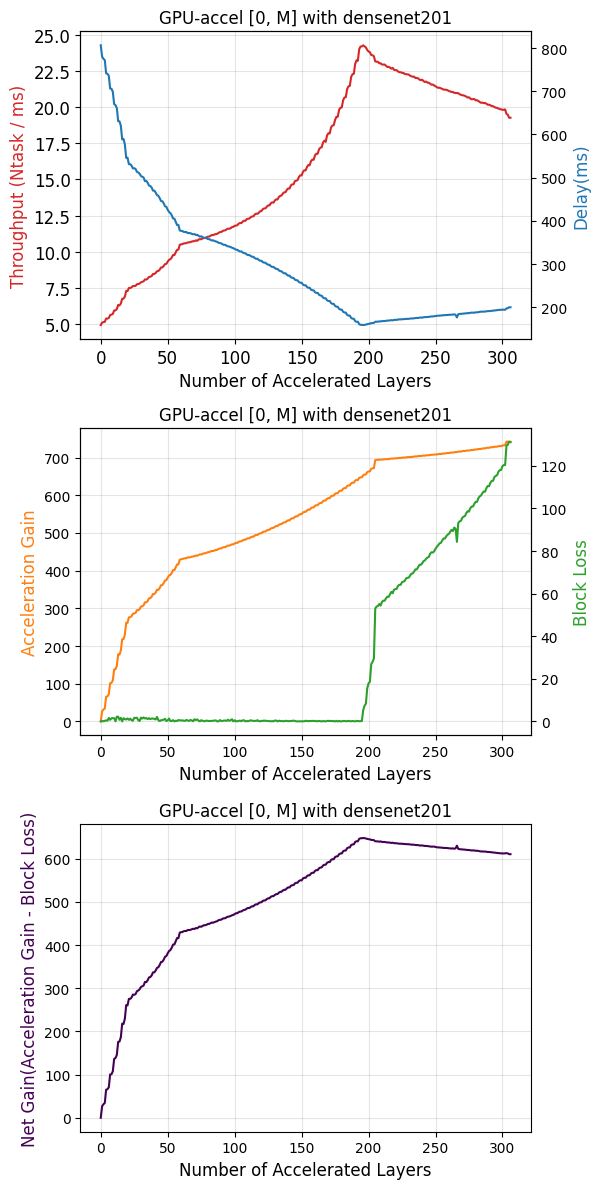

In [26]:
# Set up the plot
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, figsize=(6, 12))
ax2 = ax1.twinx()
ax4 = ax3.twinx()
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(4, 5):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color="tab:red", zorder = num_thread)
        ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color="tab:blue", zorder = num_thread)
        ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color="tab:orange", zorder = num_thread)
        ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color="tab:green", zorder = num_thread)
        ax5.plot(data_df.index, data_df[('accel_gain', num_thread)] - data_df[('block_loss', num_thread)], color=color, zorder = num_thread)
        # ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        # ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        # ax5.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)

ax1.set_xlabel('Number of Accelerated Layers', size=12)
ax3.set_xlabel('Number of Accelerated Layers', size=12)
ax5.set_xlabel('Number of Accelerated Layers', size=12)

ax1.set_ylabel("Throughput (Ntask / ms)", size=12, color="tab:red")
ax2.set_ylabel("Delay(ms)", size = 12, color="tab:blue")
ax3.set_ylabel("Acceleration Gain", size=12, color="tab:orange")
ax4.set_ylabel("Block Loss", size = 12, color="tab:green")
ax5.set_ylabel("Net Gain(Acceleration Gain - Block Loss)", size = 12, color=color)

ax1.set_title(f"GPU-accel [0, M] with {model}", size=12)
ax3.set_title(f"GPU-accel [0, M] with {model}", size=12)
ax5.set_title(f"GPU-accel [0, M] with {model}", size=12)

ax1.tick_params(axis='both', labelsize=12)
plt.tight_layout()
ax1.grid(color='gray', alpha=0.2)
ax3.grid(color='gray', alpha=0.2)
ax5.grid(color='gray', alpha=0.2)
plt.show()


##### 1. throughput and delay - glayers

In [38]:
num_accelerated_layer_list = data_df.index
max_execution_time_list = data_df[('execution_time', num_thread)]
throughput_list = data_df[('throughput', num_thread)]
acceleration_gain_list = data_df[('accel_gain', num_thread)]
block_time_list = data_df[('block_loss', num_thread)]

MAX Throughput Index: 196
MAX Throughput: 24.263088499614728
Corresponding Number of Accelerated Layers: 196
Corresponding Delay: 158.5496052631579


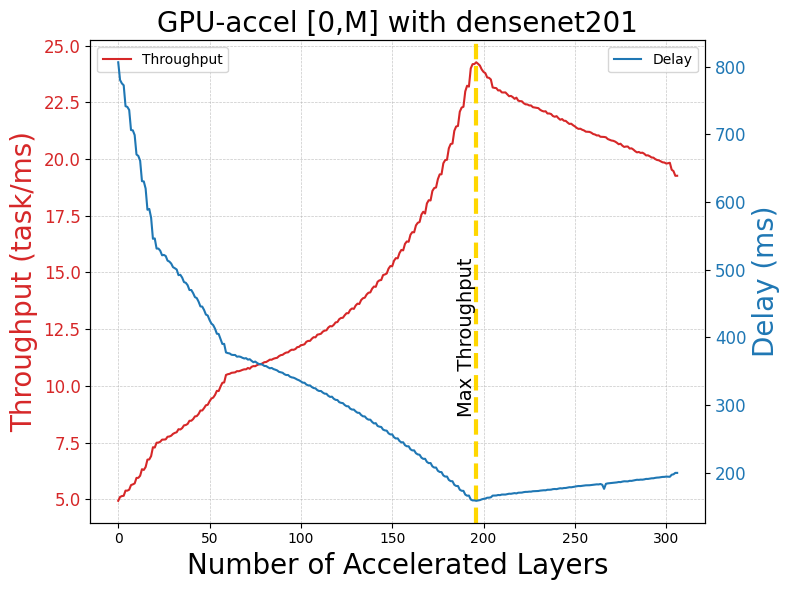

In [39]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Delay (ms)", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_max_execution_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_throughput_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/Throughput_Delay-GLayer-{device}-{type}-{model}-{date_label}.{save_format}')

##### 2. acceleration gain and block loss - glayers

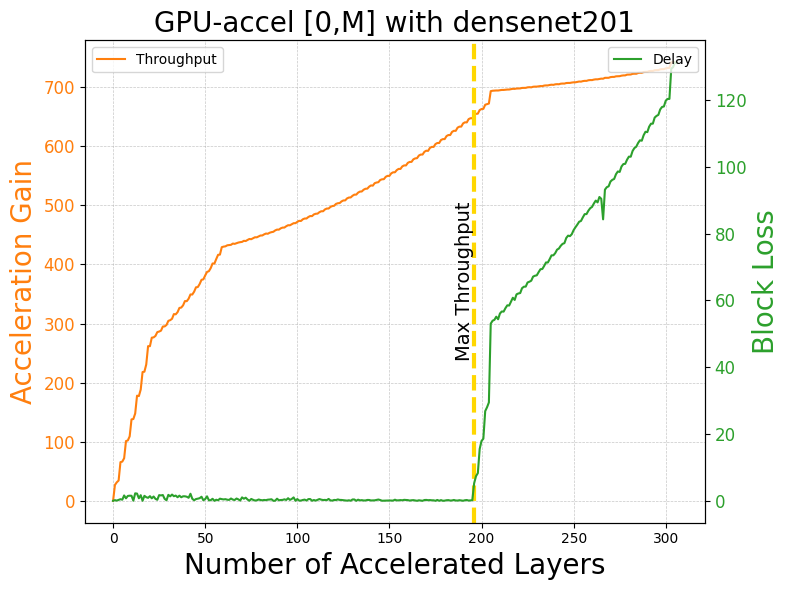

In [40]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_ylabel("Acceleration Gain", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Block Loss", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_block_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_acceleration_gain_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/AccelGain_BlockLoss-GLayer-{device}-{type}-{model}-{date_label}.{save_format}')

##### 3. net gain - glayers

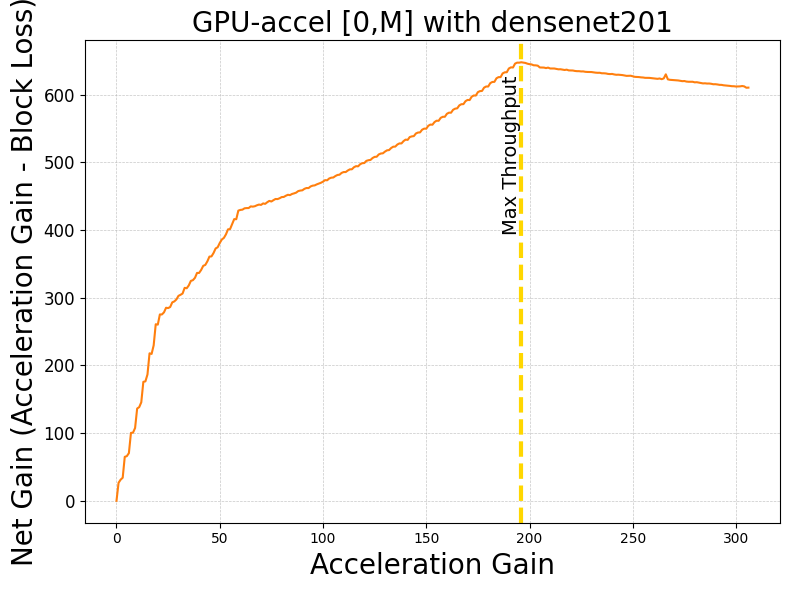

In [41]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)
net_gain_list = [a - b for a, b in zip(sorted_acceleration_gain_list, sorted_block_time_list)]

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.set_ylabel("Net Gain (Acceleration Gain - Block Loss)", size=20)
ax1.plot(sorted_num_accelerated_layer_list, net_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.mean(net_gain_list), "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)


plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/NetGain-GLayer-{device}-{type}-{model}-{date_label}.{save_format}')

##### 4. throughput - delay

MAX Throughput Index: 196
MAX Throughput: 24.263088499614728
Corresponding Number of Accelerated Layers: 196
Corresponding Delay: 158.5496052631579


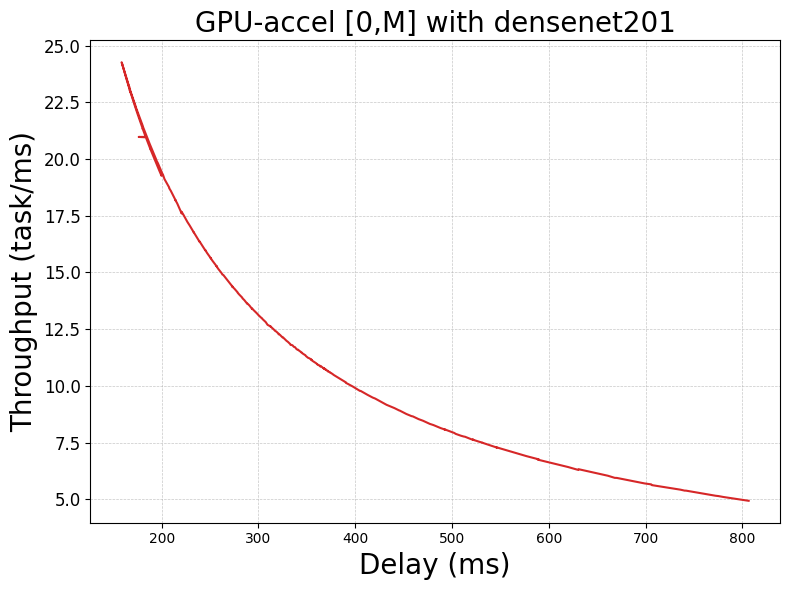

In [42]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", size=20)
ax1.set_xlabel("Delay (ms)", size=20)
ax1.plot(sorted_max_execution_time_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/Throughput-Delay-{device}-{type}-{model}-{date_label}.{save_format}')

##### 5. block loss - acceleration gain

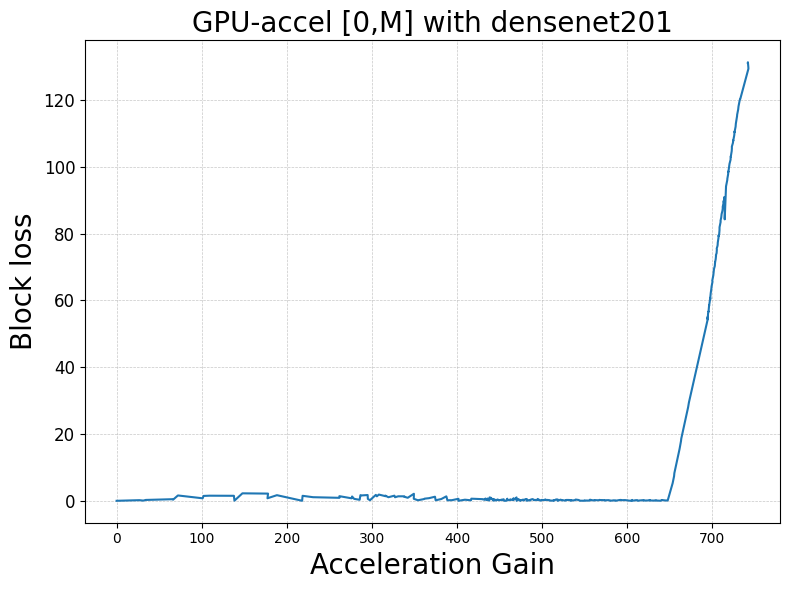

In [43]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:blue"
ax1.set_ylabel("Block loss", size=20)
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.plot(sorted_acceleration_gain_list, sorted_block_time_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.title(f"GPU-accel [0,M] with {model}", size=20)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{save_format}/BlockLos-AccelGain-{device}-{type}-{model}-{date_label}.{save_format}')


### 기본그래프
### 이거 무슨 그래프인지 잘 모르겠음

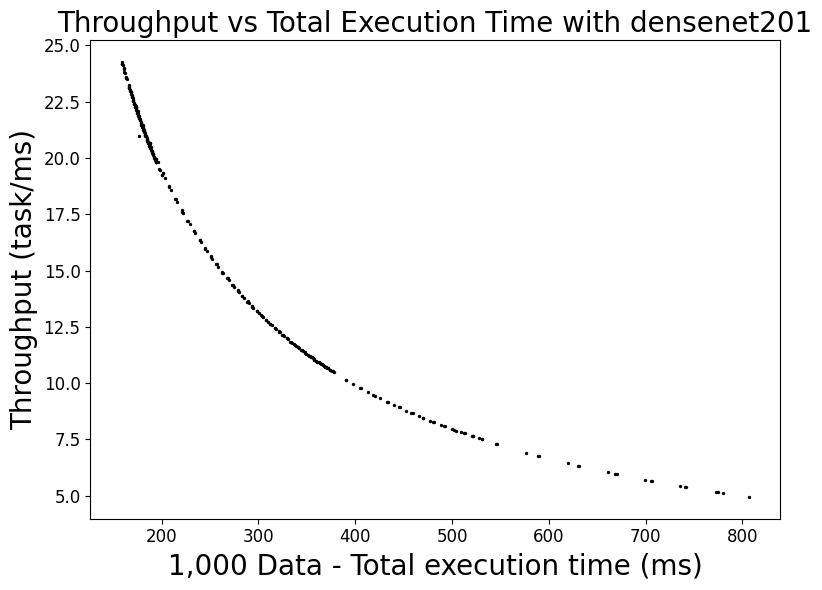

In [55]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(max_execution_time_list, throughput_list, color=color, s= 2)

ax1.set_xlabel('1,000 Data - Total execution time (ms)', size=20)
ax1.set_ylabel("Throughput (task/ms)", size=20)

ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Throughput vs Total Execution Time with {model}", fontsize=20)
plt.tight_layout()
plt.show()

# Set up the plo/

In [45]:
# [0,M] & [start, M] 구성 찾기
all_results = []

# 모든 start 값에 대한 배열 생성
for start in range(0, 1):
    result = []
    for i in range(start, layer_num-2):
        row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num -2 - (i + 1)) + [0]
        result.append(row)
    all_results.append(result)

# 각 배열이 acceleration_type에서 몇 번째 인덱스에 있는지 저장
all_results_indexes = []

for result in all_results:
    result_indexes = []
    for row in result:
        # row를 튜플로 변환하여 acceleration_type에서의 인덱스 확인
        index = acceleration_type.index(row)
        result_indexes.append(index)
    all_results_indexes.append(result_indexes)


NameError: name 'acceleration_type' is not defined

IndexError: list index out of range

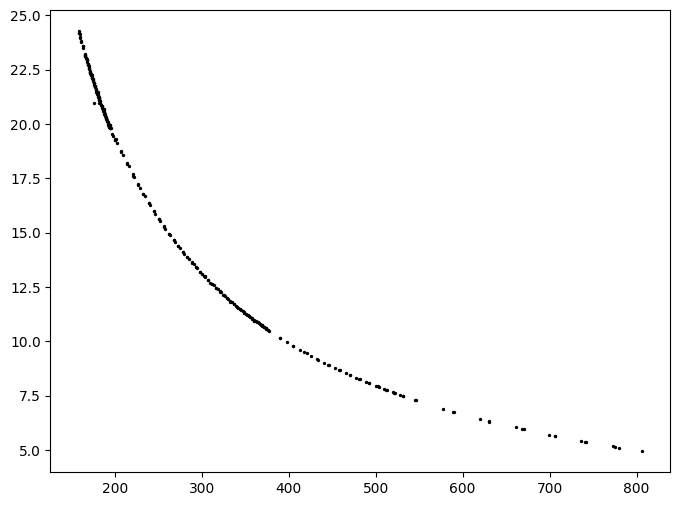

In [46]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(max_execution_time_list, throughput_list, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(max_execution_time_list[idx], throughput_list[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    print(idx)
    ax1.scatter(max_execution_time_list[idx], throughput_list[idx], color='red', s=10, zorder=2)

# Delay에는 Block time이 포함됨
ax1.set_xlabel('Delay (ms)', size=20)
ax1.set_ylabel("Throughput (task/ms)", size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Impact of Delay on Throughput with {model}", fontsize=20)

plt.tight_layout()
plt.show()

In [56]:
# throughput_list에서 최대값, 해당 인덱스, 그리고 max_execution_time_list 값을 찾기
max_throughput = max(throughput_list)
max_index = list(throughput_list).index(max_throughput)
corresponding_execution_time = max_execution_time_list[max_index]
corresponding_acceleration_type = acceleration_type[max_index]

# 결과 출력
print(f"최대 Throughput 값: {max_throughput}")
print(f"최대 Throughput이 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 avg_execution_time: {corresponding_execution_time}")
print(f"해당 인덱스의 acceleration_type: {corresponding_acceleration_type}")

print(len(corresponding_acceleration_type))
print(corresponding_acceleration_type)

# 합 계산
total_inference_time = sum(
    cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
    for i in range(len(corresponding_acceleration_type))
)

# 결과 출력
total_cpu_time = sum(cpu_inference_list)
acceleration_gain = total_cpu_time - total_inference_time
print(f"\n전체 CPU 실행 inference 시간: {total_cpu_time}")
print(f"최종 합산된 inference 시간: {total_inference_time}")
print(f"가속 이득: {acceleration_gain}")
block_time = max_execution_time-total_inference_time
print(f"블락 손실: {block_time}")

NameError: name 'acceleration_type' is not defined

IndexError: list index out of range

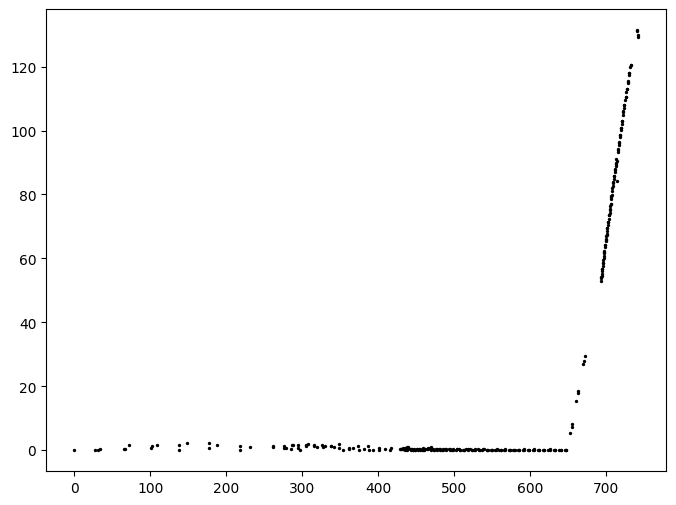

In [48]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(acceleration_gain_list, block_time_list, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='red', s=10, zorder=2)


ax1.set_xlabel('Acceleraion Gain (ms)', size=20)
ax1.set_ylabel("Block Loss (ms)", size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Block Loss vs Acceleraion Gain with {model}", fontsize=20)

plt.tight_layout()
plt.show()

print(len(throughput_list))

# throughput_list에서 최대값, 해당 인덱스, 그리고 max_execution_time_list 값을 찾기
max_throughput = max(acceleration_gain_list)
max_index = acceleration_gain_list.index(max_throughput)
corresponding_execution_time = block_time_list[max_index]
corresponding_acceleration_type = acceleration_type[max_index]

# 결과 출력
print(f"최대 acceleration_gain_list 값: {max_throughput}")
print(f"최대 acceleration_gain_list 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 block_time_list: {corresponding_execution_time}")
print(f"해당 인덱스의 acceleration_type: {corresponding_acceleration_type}")


IndexError: list index out of range

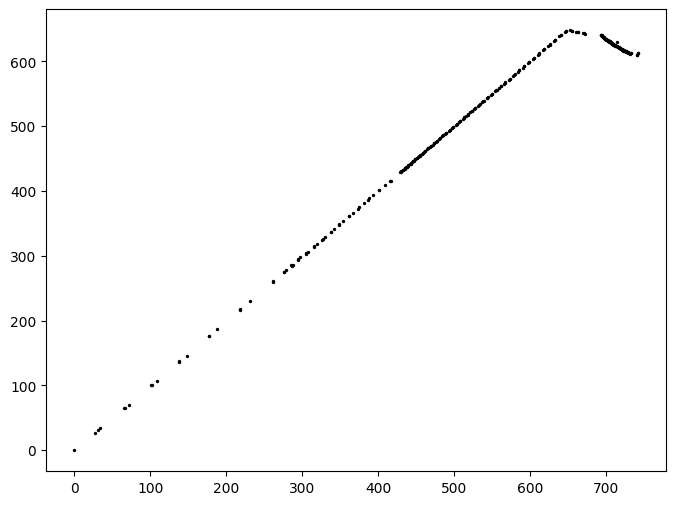

In [49]:
# acceleration_gain - block_time 계산
loss_difference = [acc - block for acc, block in zip(acceleration_gain_list, block_time_list)]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# 흑색으로 전체 데이터 점 표현
color = "black"
ax1.scatter(acceleration_gain_list, loss_difference, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(acceleration_gain_list[idx], loss_difference[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    ax1.scatter(acceleration_gain_list[idx], loss_difference[idx], color='red', s=10, zorder=2)

# 축 라벨 및 설정
ax1.set_xlabel('Acceleration Gain (ms)', size=20)
ax1.set_ylabel('Net Gain (Acceleration - Block Loss) (ms)', size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Net Gain vs Acceleraion Gain with {model}", fontsize=20)

# 그래프 표시
plt.tight_layout()
plt.show()

# 최대 acceleration_gain - block_time 값을 찾기
max_difference = max(loss_difference)
max_index = loss_difference.index(max_difference)
corresponding_acceleration_gain = acceleration_gain_list[max_index]
corresponding_block_time = block_time_list[max_index]

# 결과 출력
print(f"최대 acceleration_gain - block_time 값: {max_difference}")
print(f"최대값 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 acceleration_gain: {corresponding_acceleration_gain}")
print(f"해당 인덱스의 block_time: {corresponding_block_time}")


IndexError: list index out of range

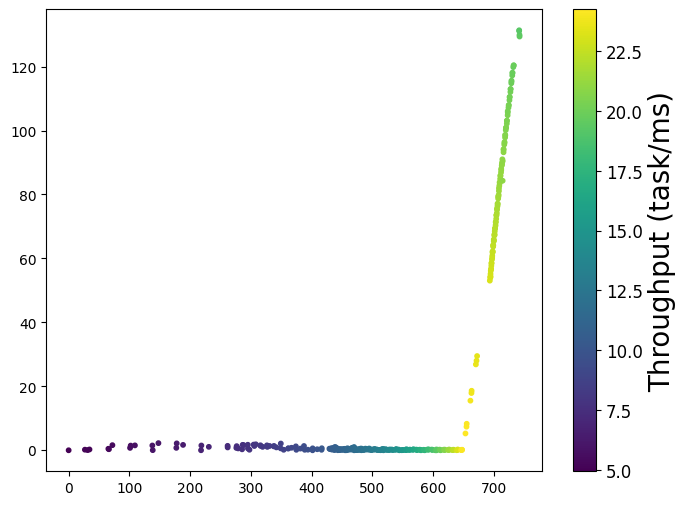

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Normalize throughput_list for color mapping
norm_throughput = (throughput_list - np.min(throughput_list)) / (np.max(throughput_list) - np.min(throughput_list))

# Scatter plot with z-axis represented by colors
scatter = ax1.scatter(
    acceleration_gain_list, 
    block_time_list, 
    c=throughput_list, # norm_throughput
    cmap='viridis',  # Choose a color map
    s=10,  # Adjust size of points
    zorder=1
)

# Colorbar for throughput values
cbar = fig.colorbar(scatter, ax=ax1)
cbar.set_label('Throughput (task/ms)', size=20)
cbar.ax.tick_params(labelsize=12)

# start=0 points highlighted in red
for idx in all_results_indexes[0]:  # Points corresponding to start=0
    ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='red', s=30, zorder=-100)

# Axis labels
ax1.set_xlabel('Acceleration Gain (ms)', size=20)
ax1.set_ylabel('Block Time (ms)', size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"{model}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
plt.tight_layout()
plt.show()

# Maximum throughput analysis
max_throughput = max(throughput_list)
max_index = throughput_list.index(max_throughput)
corresponding_acceleration_gain = acceleration_gain_list[max_index]
corresponding_block_time = block_time_list[max_index]

# Results output
print(f"최대 throughput 값: {max_throughput}")
print(f"최대 throughput 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 acceleration_gain: {corresponding_acceleration_gain}")
print(f"해당 인덱스의 block_time: {corresponding_block_time}")


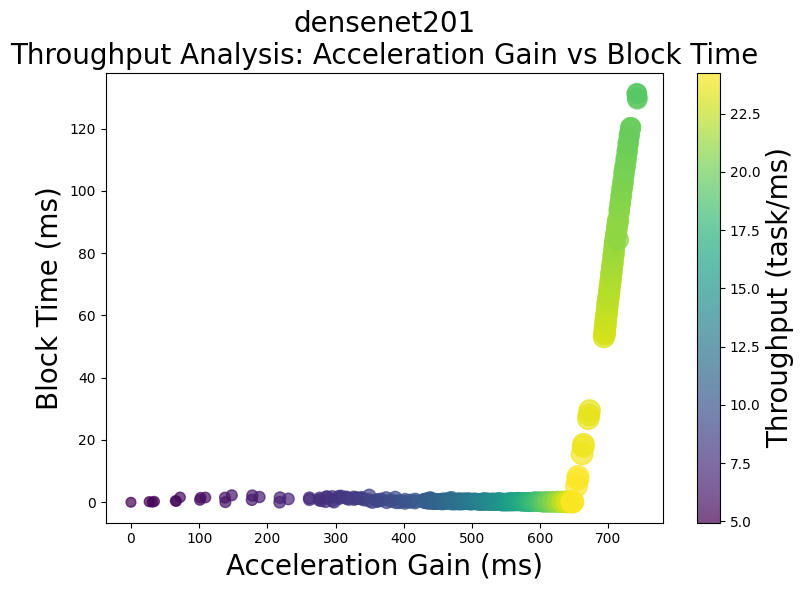

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# Bubble Chart
scatter = ax.scatter(
    acceleration_gain_list, 
    block_time_list, 
    s=np.array(throughput_list) * 10,  # 크기를 throughput_list로 설정
    c=throughput_list, 
    cmap='viridis', 
    alpha=0.7
)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Throughput (task/ms)', size=20)
plt.title(f"{model}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
# Labels
ax.set_xlabel('Acceleration Gain (ms)', size=20)
ax.set_ylabel('Block Time (ms)', size=20)

plt.tight_layout()
plt.show()


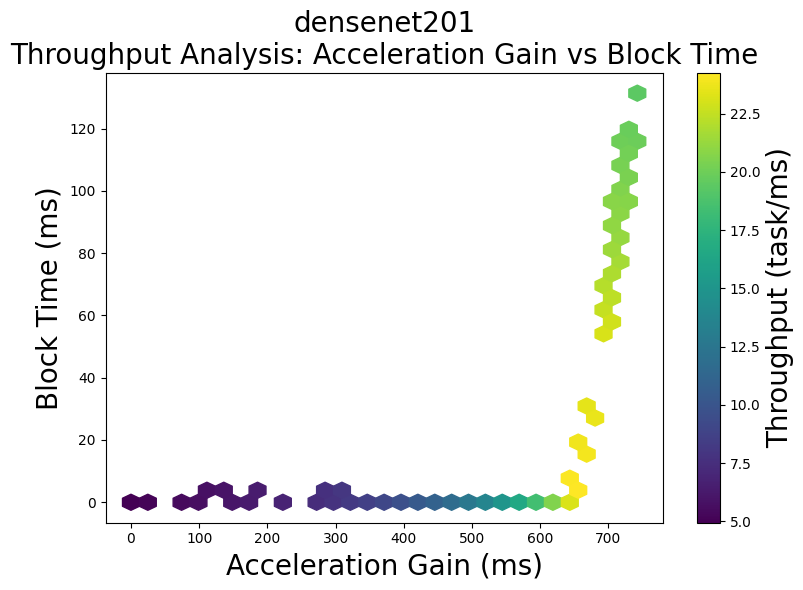

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

# Hexbin Plot
hb = ax.hexbin(
    acceleration_gain_list, 
    block_time_list, 
    C=throughput_list, 
    gridsize=30, 
    cmap='viridis'
)

# Colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Throughput (task/ms)', size=20)
plt.title(f"{model}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
# Labels
ax.set_xlabel('Acceleration Gain (ms)', size=20)
ax.set_ylabel('Block Time (ms)', size=20)

plt.tight_layout()
plt.show()


### 히스토그램

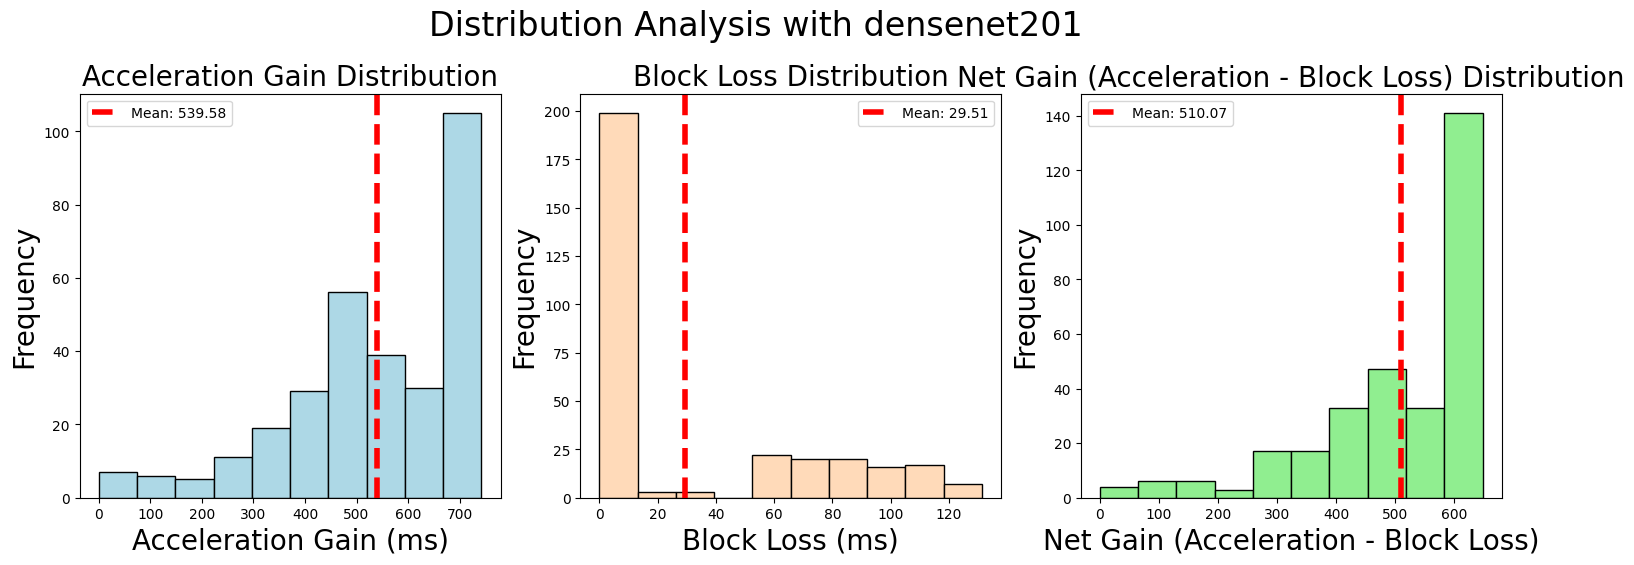

In [53]:
# 평균값 계산
acceleration_mean = np.mean(acceleration_gain_list)
block_mean = np.mean(block_time_list)
loss_mean = np.mean(loss_difference)

# 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# 첫 번째 히스토그램 (연한 파랑)
axes[0].hist(acceleration_gain_list, bins=10, edgecolor='black', color='lightblue')
axes[0].axvline(x=acceleration_mean, color='red', linestyle='--', label=f'Mean: {acceleration_mean:.2f}', linewidth=4)
axes[0].set_title("Acceleration Gain Distribution", fontsize=20)
axes[0].set_xlabel("Acceleration Gain (ms)", fontsize=20)
axes[0].set_ylabel("Frequency", fontsize=20)
axes[0].legend()

# 두 번째 히스토그램 (연한 주황)
axes[1].hist(block_time_list, bins=10, edgecolor='black', color='peachpuff')
axes[1].axvline(x=block_mean, color='red', linestyle='--', label=f'Mean: {block_mean:.2f}', linewidth=4)
axes[1].set_title("Block Loss Distribution", fontsize=20)
axes[1].set_xlabel("Block Loss (ms)", fontsize=20)
axes[1].set_ylabel("Frequency", fontsize=20)
axes[1].legend()

# 세 번째 히스토그램 (연한 초록)
axes[2].hist(loss_difference, bins=10, edgecolor='black', color='lightgreen')
axes[2].axvline(x=loss_mean, color='red', linestyle='--', label=f'Mean: {loss_mean:.2f}', linewidth=4)
axes[2].set_title("Net Gain (Acceleration - Block Loss) Distribution", fontsize=20)
axes[2].set_xlabel("Net Gain (Acceleration - Block Loss)", fontsize=20)
axes[2].set_ylabel("Frequency", fontsize=20)
axes[2].legend()

# 그래프 출력
fig.suptitle(f"Distribution Analysis with {model}", fontsize=24, y=1.1)
plt.show()